[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_use_forecaster_to_predict_future_data.ipynb)


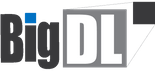

# Predict future data

## Introduction

Once we have trained a forecaster and validate its performance and accuracy, it's time to predict future data. In this guidance, **we demonstrate how to use forecaster to predict future data with and without ground truth** in detail.

We will take `TCNForecaster` and nyc_taxi dataset as an example in this guide.

## Setup

To begin our guide, you should prepare your environment and your dataset as introduced in former guides.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict

## Forecaster preparation

Before prediction, a forecaster should be created and trained. The training process is introduced in the previous guidance [Train forcaster on single node](https://bigdl.readthedocs.io/en/latest/doc/Chronos/Howto/how_to_train_forecaster_on_one_node.html) in detail, therefore we directly create and train a `TCNForecaster` based on the nyc taxi dataset.

In [3]:
# data preparation
def get_data():
    from bigdl.chronos.data import get_public_dataset
    from sklearn.preprocessing import StandardScaler

    # load the nyc taxi dataset
    tsdata_train, tsdata_val, tsdata_test = get_public_dataset(name='nyc_taxi')

    stand = StandardScaler()
    for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
        tsdata.impute()\
              .scale(stand, fit=tsdata is tsdata_train)

    return tsdata_train, tsdata_test

# trained forecaster preparation
def get_trained_forecaster(train_data):
    from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
    # create a TCNForecaster
    forecaster = TCNForecaster(past_seq_len=48,
                               future_seq_len=1,
                               input_feature_num=1,
                               output_feature_num=1)

    # train the forecaster on the training data
    forecaster.fit(train_data)
    return forecaster

## Prediction

There are two application scenarios for prediction : **prediction with ground truth to validate** and **pure prediction** (without ground truth). 

For different kinds of prediction, the process about how to prepare your dataset differs. We will introduce the examples for different scenarios separately.

### 1. Prediction with ground truth

When a forecaster is trained, we provide with `predict` to predict on test data. The data support following formats:

1. `bigdl.chronos.data.TSDataset` (**recommended**)
2. numpy ndarray
3. pytorch dataloader
4. xshard item

It's always recommended to use `TSDataset` direcetly when possible. 

The `batch_size` will not affect prediction result but will affect resources cost and the default value is 32. Besides, `quantize` can be set to `True` to use the quantized model to predict.

In [ ]:
# get TSDataset for training and testing
tsdata_train, tsdata_test = get_data()
tsdata_train.roll(lookback=48, horizon=1)
# get a trained forecaster
forecaster = get_trained_forecaster(tsdata_train)

In [ ]:
# if predict with ground truth, you should set parameter in roll like this:
tsdata_test.roll(lookback=48, horizon=1)
# prediction using forecaster
pred = forecaster.predict(tsdata_test)

> 📝**Note**
> 
> If you are using AutoformerForecaster, don't forget to set `time_enc=True` in tsdataset.roll.

Congrats! So far you have already finished your first try of `forecaster.predict` successfully. But there is **one more thing** you need to do. 

We should know that we scaled our datasets both for trainning and for predicting by using `tsdataset.scale` when we prepared the dataset before. So the result of prediction here (denoted by `pred`) is also scaled. To get the result in original scale, we have to use `tsdataset.unscale_numpy` to unscale the result. 

The input of `tsdataset.unscale_numpy` is a numpy ndarray, which is actually the return value of `forecaster.predict` function. So what we need to do is just passing the result into the `tsdataset.unscale_numpy` function to get the unscaled result.

In [7]:
# Unscale the predict value to get the result in correct scale
pred_unscale = tsdata_test.unscale_numpy(data=pred)

### 2. Prediction without ground truth (pure prediction)

To make a pure prediction, the only change is to set `is_predict=True` in `tsdataset.roll`. This will enable you to predict target features of unobserved timestamps.

In [ ]:
# if predict without ground truth, you should set parameter in roll like this:
tsdata_test.roll(lookback=48, horizon=1, is_predict=True)
# prediction using forecaster
pred = forecaster.predict(tsdata_test)

> 📝**Note**
> 
> If you are using AutoformerForecaster, don't forget to set `time_enc=True` in tsdataset.roll.

Then how to get the unscaled result is the same as before.